In [ ]:
%matplotlib inline
import numpy as np
import torch
from torch import nn, optim
from torchvision import transforms, datasets
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

## Загрузка данных

In [ ]:
dataset  = datasets.MNIST(root='./data/',
                            train=True,
                            transform=transforms.Compose(
                                  [transforms.ToTensor(),
                                  transforms.Normalize((0.5),(0.5))]),
                            download=True)

In [ ]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)
num_batches = len(data_loader)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Метод для генерации рандомного шума (вход в генератор)

In [ ]:
def random_noise(batch_size):
    n = torch.randn(batch_size, 100)
    return n.to(device)

Метод для показа изображений (много преобразовательной магии, не вникайте в этот метод пожалуйста)

In [ ]:
def visualise(imgs, rows=2):
    imgs = imgs.view(-1, 1, 28, 28)
    imgs = (imgs.transpose(1, 3) + 1) / 2
    imgs = torch.cat([imgs[i::rows] for i in range(rows)], dim=1)
    cols = len(imgs)
    imgs = np.squeeze((torch.cat(list(imgs), dim=1)).cpu().numpy()[:, :, ::-1])
    plt.figure(figsize=(cols*1.5, rows*1.5))
    plt.imshow(imgs, cmap = 'gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## Модули

In [ ]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [ ]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x


In [ ]:
discriminator = Discriminator()
generator = Generator()
discriminator.to(device)
generator.to(device)

Generator(
  (hidden0): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden1): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden2): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (out): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
  )
)

## Оптимизация и функция потерь

In [ ]:
# Оптимизаторы
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Функция потерь
loss = nn.BCELoss()

num_epochs = 200

## Методы для обчуения генератора и дискриминатора

In [ ]:
def train_discriminator(optimizer, real_data, fake_data):
    # обнуляем градиенты
    optimizer.zero_grad()
    
    # Обучение на настоящей выборке
    prediction_real = discriminator(real_data)
    # Считаем лосс для настоящих данных и делаем backpropagate

    real_data_target = torch.ones(real_data.size(0), 1)
    real_data_target = real_data_target.to(device)

    error_real = loss(prediction_real, real_data_target)
    error_real.backward()

    # Обучение на сгенерированной выборке
    prediction_fake = discriminator(fake_data)
    # Считаем лосс для фейковых данных и делаем backpropagate

    fake_data_target = torch.zeros(real_data.size(0), 1)
    fake_data_target =  fake_data_target.to(device)
    error_fake = loss(prediction_fake, fake_data_target)


    error_fake.backward()
    optimizer.step()
    
    # возвращаем ошибку а также выход дискриминатора на истинной картинке и фейковой
    return error_real + error_fake

def train_generator(optimizer, fake_data):
    # обнуляем градиенты
    optimizer.zero_grad()

    prediction = discriminator(fake_data)
    # считаем лосс между сгенеренной картинкой и истинной
    real_data_target = torch.ones(prediction.size(0), 1)
    real_data_target = real_data_target.to(device)
    error = loss(prediction, real_data_target)
    
    error.backward()
    optimizer.step()
    return error

In [ ]:
visualise_every = 1

### Начинаем обучать

  0%|          | 0/600 [00:00<?, ?it/s]

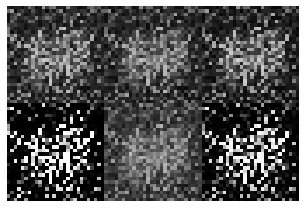

Epoch 1 | Discriminator loss: 0.6569654621921169 | Generator loss: 4.18441911102583


  0%|          | 0/600 [00:00<?, ?it/s]

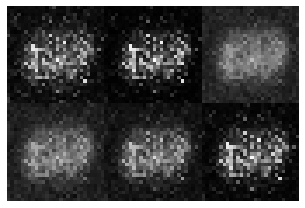

Epoch 2 | Discriminator loss: 0.9721144211043914 | Generator loss: 2.587555448015531


  0%|          | 0/600 [00:00<?, ?it/s]

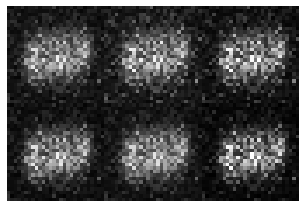

Epoch 3 | Discriminator loss: 1.0626871999601524 | Generator loss: 1.5342532055576643


  0%|          | 0/600 [00:00<?, ?it/s]

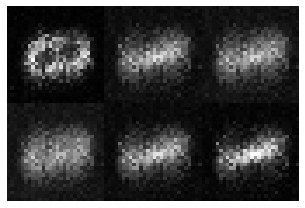

Epoch 4 | Discriminator loss: 0.5785671129574378 | Generator loss: 2.7745675959189735


  0%|          | 0/600 [00:00<?, ?it/s]

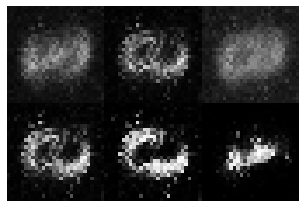

Epoch 5 | Discriminator loss: 0.4729459259659052 | Generator loss: 3.2779224433501564


  0%|          | 0/600 [00:00<?, ?it/s]

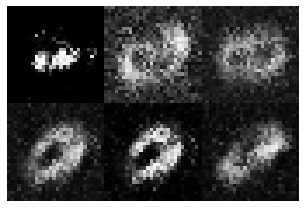

Epoch 6 | Discriminator loss: 0.5374992744624615 | Generator loss: 2.804806498090426


  0%|          | 0/600 [00:00<?, ?it/s]

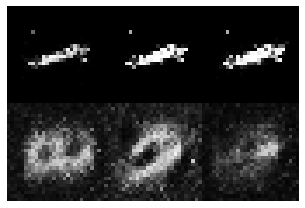

Epoch 7 | Discriminator loss: 0.5038678295165301 | Generator loss: 2.94998694340388


  0%|          | 0/600 [00:00<?, ?it/s]

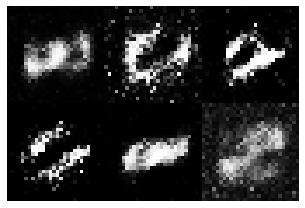

Epoch 8 | Discriminator loss: 0.5485006005813678 | Generator loss: 2.7786614042520523


  0%|          | 0/600 [00:00<?, ?it/s]

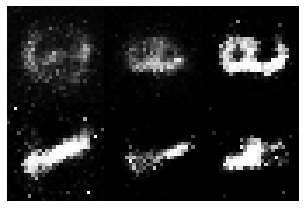

Epoch 9 | Discriminator loss: 0.6012930745383104 | Generator loss: 2.5728513437509535


  0%|          | 0/600 [00:00<?, ?it/s]

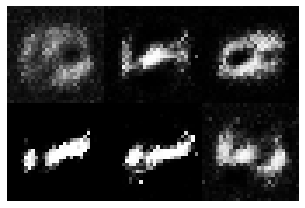

Epoch 10 | Discriminator loss: 0.6406738225122293 | Generator loss: 2.4069791269302367


  0%|          | 0/600 [00:00<?, ?it/s]

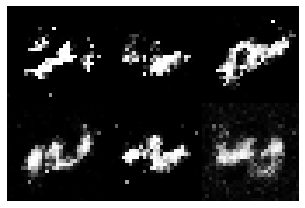

Epoch 11 | Discriminator loss: 0.6529330395658811 | Generator loss: 2.3316367987791695


  0%|          | 0/600 [00:00<?, ?it/s]

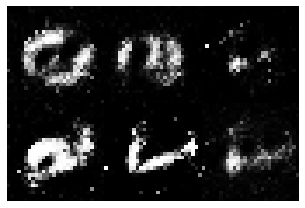

Epoch 12 | Discriminator loss: 0.6820620926221211 | Generator loss: 2.238043215672175


  0%|          | 0/600 [00:00<?, ?it/s]

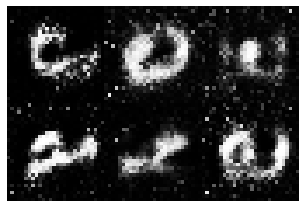

Epoch 13 | Discriminator loss: 0.7382255259652932 | Generator loss: 2.2093920608361564


  0%|          | 0/600 [00:00<?, ?it/s]

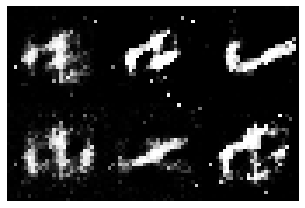

Epoch 14 | Discriminator loss: 0.7834953613082568 | Generator loss: 1.9987303229173023


  0%|          | 0/600 [00:00<?, ?it/s]

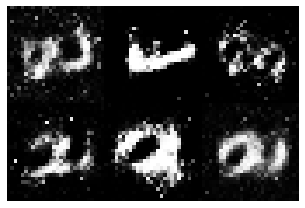

Epoch 15 | Discriminator loss: 0.8075885484119256 | Generator loss: 1.857770946820577


  0%|          | 0/600 [00:00<?, ?it/s]

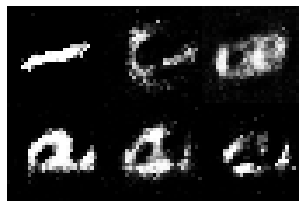

Epoch 16 | Discriminator loss: 0.8504964949687323 | Generator loss: 1.756081568201383


  0%|          | 0/600 [00:00<?, ?it/s]

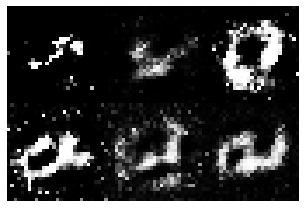

Epoch 17 | Discriminator loss: 0.8790627698103587 | Generator loss: 1.7076776659488677


  0%|          | 0/600 [00:00<?, ?it/s]

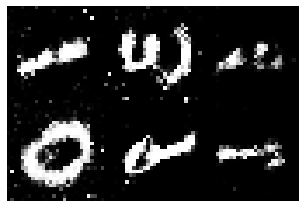

Epoch 18 | Discriminator loss: 0.8432435623804728 | Generator loss: 1.7712430075804393


  0%|          | 0/600 [00:00<?, ?it/s]

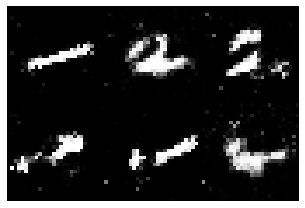

Epoch 19 | Discriminator loss: 0.8429812538127105 | Generator loss: 1.8075913043816885


  0%|          | 0/600 [00:00<?, ?it/s]

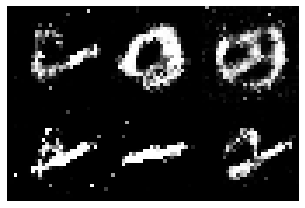

Epoch 20 | Discriminator loss: 0.8916997952262561 | Generator loss: 1.651064299941063


  0%|          | 0/600 [00:00<?, ?it/s]

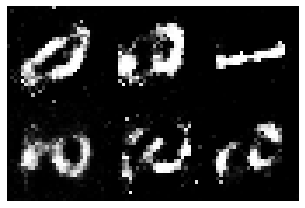

Epoch 21 | Discriminator loss: 0.9062893062829971 | Generator loss: 1.63829918384552


  0%|          | 0/600 [00:00<?, ?it/s]

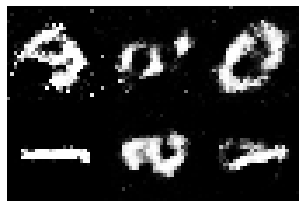

Epoch 22 | Discriminator loss: 0.9448802889386813 | Generator loss: 1.5398380266626677


  0%|          | 0/600 [00:00<?, ?it/s]

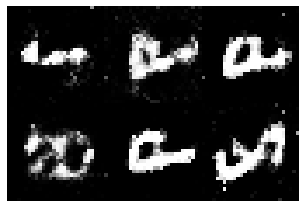

Epoch 23 | Discriminator loss: 0.9539888421694438 | Generator loss: 1.4904710119962692


  0%|          | 0/600 [00:00<?, ?it/s]

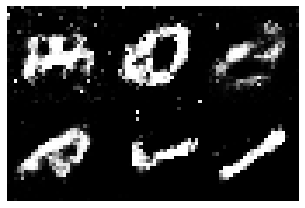

Epoch 24 | Discriminator loss: 0.9549063942829767 | Generator loss: 1.5243233052889507


  0%|          | 0/600 [00:00<?, ?it/s]

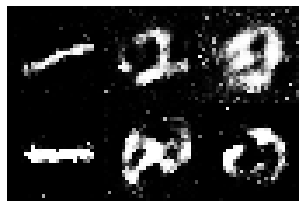

Epoch 25 | Discriminator loss: 0.9584053165713946 | Generator loss: 1.5099334957202275


  0%|          | 0/600 [00:00<?, ?it/s]

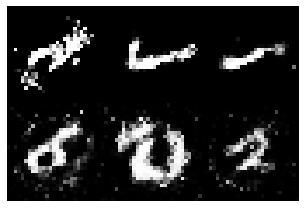

Epoch 26 | Discriminator loss: 0.9555802243947983 | Generator loss: 1.5119474682211875


  0%|          | 0/600 [00:00<?, ?it/s]

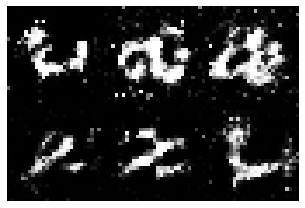

Epoch 27 | Discriminator loss: 0.9822215621670087 | Generator loss: 1.4385403922200204


  0%|          | 0/600 [00:00<?, ?it/s]

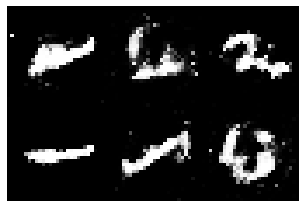

Epoch 28 | Discriminator loss: 0.97142153352499 | Generator loss: 1.4452661203344663


  0%|          | 0/600 [00:00<?, ?it/s]

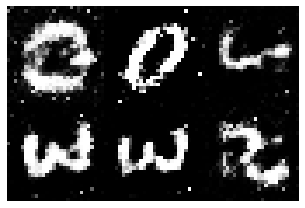

Epoch 29 | Discriminator loss: 1.011220374405384 | Generator loss: 1.397331340610981


  0%|          | 0/600 [00:00<?, ?it/s]

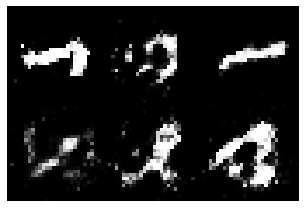

Epoch 30 | Discriminator loss: 1.0410910992821059 | Generator loss: 1.3375771995385488


  0%|          | 0/600 [00:00<?, ?it/s]

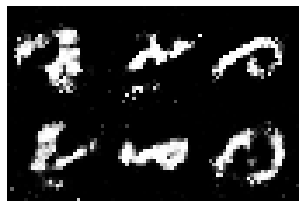

Epoch 31 | Discriminator loss: 1.0331571023662884 | Generator loss: 1.3380474847555162


  0%|          | 0/600 [00:00<?, ?it/s]

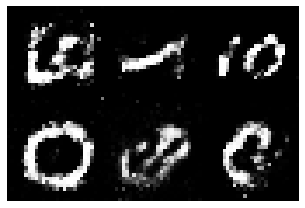

Epoch 32 | Discriminator loss: 1.056963879863421 | Generator loss: 1.2925867220759393


  0%|          | 0/600 [00:00<?, ?it/s]

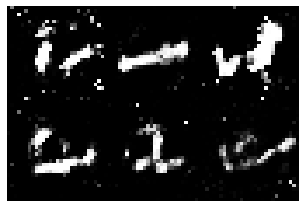

Epoch 33 | Discriminator loss: 1.0404167791207632 | Generator loss: 1.3189806151390076


  0%|          | 0/600 [00:00<?, ?it/s]

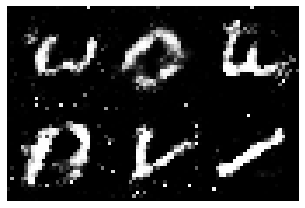

Epoch 34 | Discriminator loss: 1.032149622142315 | Generator loss: 1.3571479135751725


  0%|          | 0/600 [00:00<?, ?it/s]

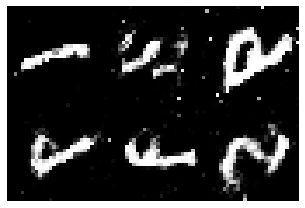

Epoch 35 | Discriminator loss: 1.065550400018692 | Generator loss: 1.2707465051611264


  0%|          | 0/600 [00:00<?, ?it/s]

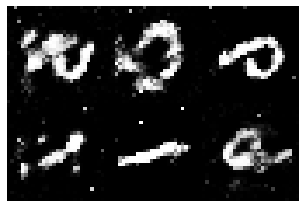

Epoch 36 | Discriminator loss: 1.0712078760067623 | Generator loss: 1.264433262248834


  0%|          | 0/600 [00:00<?, ?it/s]

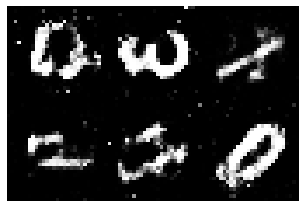

Epoch 37 | Discriminator loss: 1.0942673940459888 | Generator loss: 1.2068391343951226


  0%|          | 0/600 [00:00<?, ?it/s]

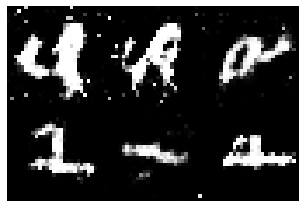

Epoch 38 | Discriminator loss: 1.1064704788724582 | Generator loss: 1.2045637059211731


  0%|          | 0/600 [00:00<?, ?it/s]

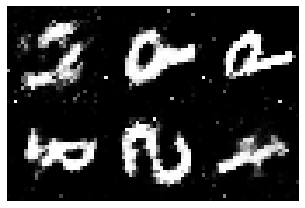

Epoch 39 | Discriminator loss: 1.113116239408652 | Generator loss: 1.1820047062635421


  0%|          | 0/600 [00:00<?, ?it/s]

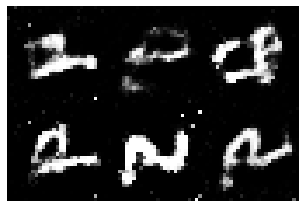

Epoch 40 | Discriminator loss: 1.1181272855401039 | Generator loss: 1.1685358200470606


  0%|          | 0/600 [00:00<?, ?it/s]

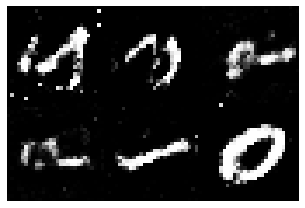

Epoch 41 | Discriminator loss: 1.128289182583491 | Generator loss: 1.1560412416855494


  0%|          | 0/600 [00:00<?, ?it/s]

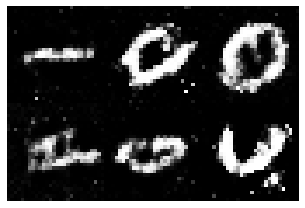

Epoch 42 | Discriminator loss: 1.1231900054216384 | Generator loss: 1.1511430957913398


  0%|          | 0/600 [00:00<?, ?it/s]

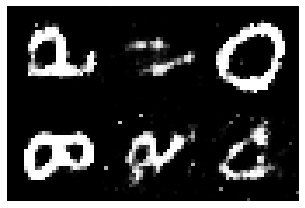

Epoch 43 | Discriminator loss: 1.1407144673665364 | Generator loss: 1.1384348025918007


  0%|          | 0/600 [00:00<?, ?it/s]

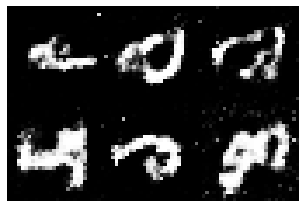

Epoch 44 | Discriminator loss: 1.147372198700905 | Generator loss: 1.1179906128843626


  0%|          | 0/600 [00:00<?, ?it/s]

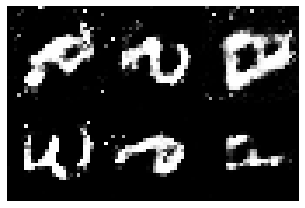

Epoch 45 | Discriminator loss: 1.161027416686217 | Generator loss: 1.0890465891361236


  0%|          | 0/600 [00:00<?, ?it/s]

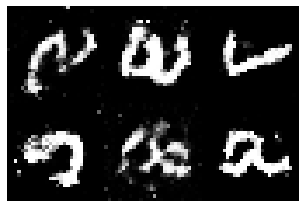

Epoch 46 | Discriminator loss: 1.1627057668566705 | Generator loss: 1.1071727426846822


  0%|          | 0/600 [00:00<?, ?it/s]

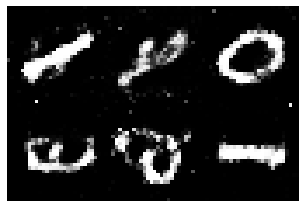

Epoch 47 | Discriminator loss: 1.1532021562258403 | Generator loss: 1.1181105804443359


  0%|          | 0/600 [00:00<?, ?it/s]

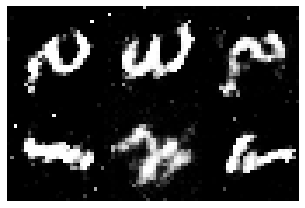

Epoch 48 | Discriminator loss: 1.160841470261415 | Generator loss: 1.0964486986398696


  0%|          | 0/600 [00:00<?, ?it/s]

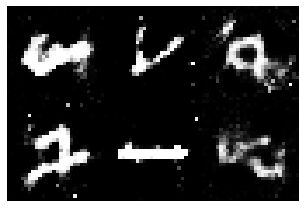

Epoch 49 | Discriminator loss: 1.16973824908336 | Generator loss: 1.0782078260183334


  0%|          | 0/600 [00:00<?, ?it/s]

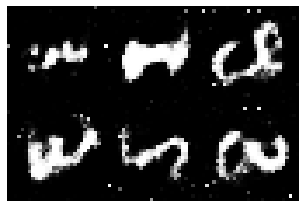

Epoch 50 | Discriminator loss: 1.172656192580859 | Generator loss: 1.065006912946701


  0%|          | 0/600 [00:00<?, ?it/s]

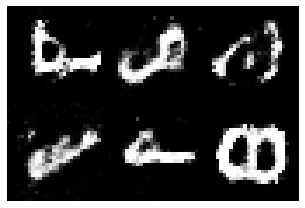

Epoch 51 | Discriminator loss: 1.1816466125845908 | Generator loss: 1.0551452871163687


  0%|          | 0/600 [00:00<?, ?it/s]

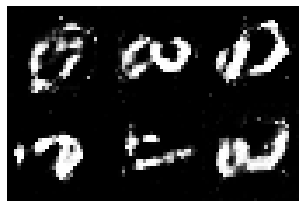

Epoch 52 | Discriminator loss: 1.1809885122378667 | Generator loss: 1.0622776019573212


  0%|          | 0/600 [00:00<?, ?it/s]

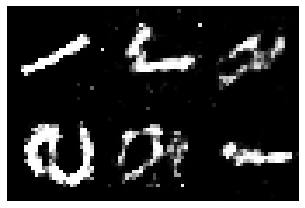

Epoch 53 | Discriminator loss: 1.1819573014974594 | Generator loss: 1.0591542130708695


  0%|          | 0/600 [00:00<?, ?it/s]

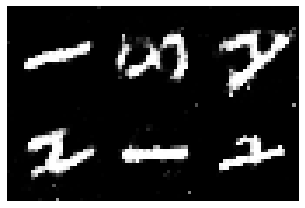

Epoch 54 | Discriminator loss: 1.186929333905379 | Generator loss: 1.058843906323115


  0%|          | 0/600 [00:00<?, ?it/s]

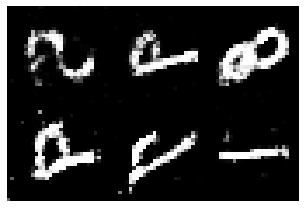

Epoch 55 | Discriminator loss: 1.180923039019108 | Generator loss: 1.0515111914277078


  0%|          | 0/600 [00:00<?, ?it/s]

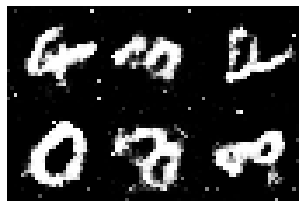

Epoch 56 | Discriminator loss: 1.1816040632128715 | Generator loss: 1.05211349238952


  0%|          | 0/600 [00:00<?, ?it/s]

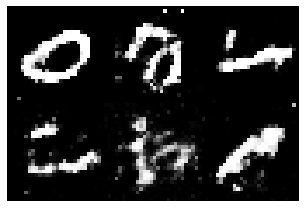

Epoch 57 | Discriminator loss: 1.1845048051079115 | Generator loss: 1.064468576014042


  0%|          | 0/600 [00:00<?, ?it/s]

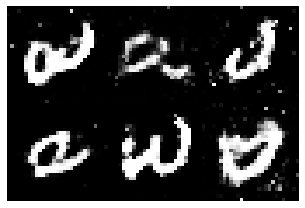

Epoch 58 | Discriminator loss: 1.1814052331447602 | Generator loss: 1.0518974857529004


  0%|          | 0/600 [00:00<?, ?it/s]

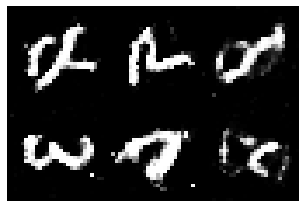

Epoch 59 | Discriminator loss: 1.1873496080438295 | Generator loss: 1.0453879433870314


  0%|          | 0/600 [00:00<?, ?it/s]

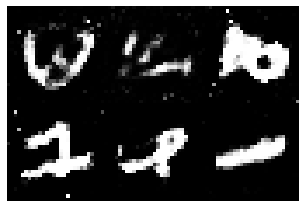

Epoch 60 | Discriminator loss: 1.190423726439476 | Generator loss: 1.0340014974276224


  0%|          | 0/600 [00:00<?, ?it/s]

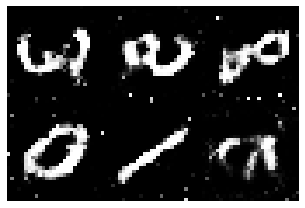

Epoch 61 | Discriminator loss: 1.191488206088543 | Generator loss: 1.044813323020935


  0%|          | 0/600 [00:00<?, ?it/s]

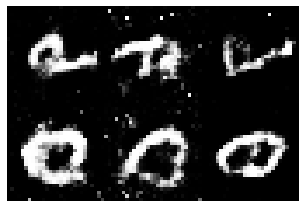

Epoch 62 | Discriminator loss: 1.1856749853491784 | Generator loss: 1.0458760914206504


  0%|          | 0/600 [00:00<?, ?it/s]

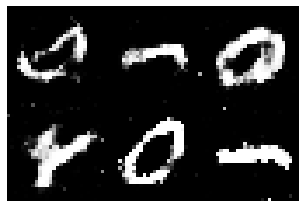

Epoch 63 | Discriminator loss: 1.20038467725118 | Generator loss: 1.0207066147526105


  0%|          | 0/600 [00:00<?, ?it/s]

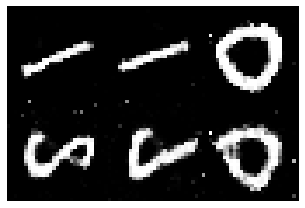

Epoch 64 | Discriminator loss: 1.203841186563174 | Generator loss: 1.0236372420191764


  0%|          | 0/600 [00:00<?, ?it/s]

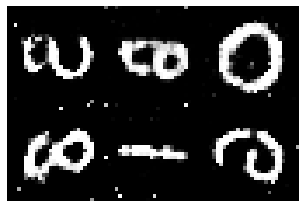

Epoch 65 | Discriminator loss: 1.2028022482991219 | Generator loss: 1.0147872873147328


  0%|          | 0/600 [00:00<?, ?it/s]

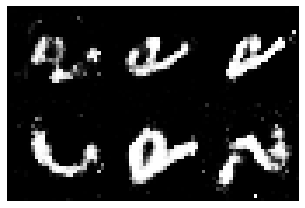

Epoch 66 | Discriminator loss: 1.2040357422828674 | Generator loss: 1.01934645652771


  0%|          | 0/600 [00:00<?, ?it/s]

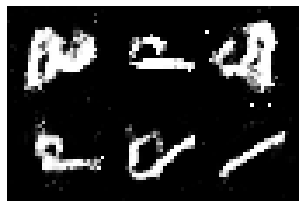

Epoch 67 | Discriminator loss: 1.2067452050248781 | Generator loss: 1.0221303493777911


  0%|          | 0/600 [00:00<?, ?it/s]

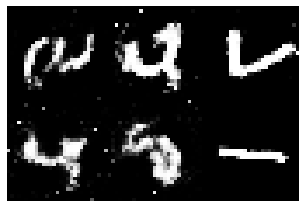

Epoch 68 | Discriminator loss: 1.2059708577394486 | Generator loss: 1.0191549768050512


  0%|          | 0/600 [00:00<?, ?it/s]

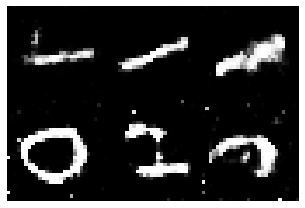

Epoch 69 | Discriminator loss: 1.2149861214558284 | Generator loss: 0.9924638028939565


  0%|          | 0/600 [00:00<?, ?it/s]

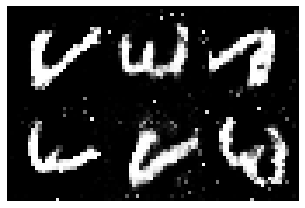

Epoch 70 | Discriminator loss: 1.215140118499597 | Generator loss: 1.004063556790352


  0%|          | 0/600 [00:00<?, ?it/s]

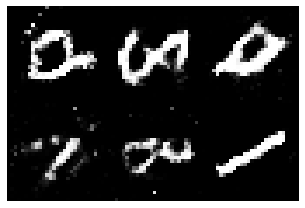

Epoch 71 | Discriminator loss: 1.2245558905601501 | Generator loss: 0.9893715168039005


  0%|          | 0/600 [00:00<?, ?it/s]

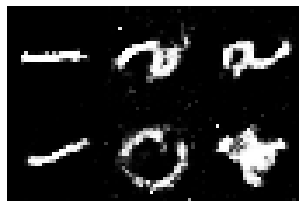

Epoch 72 | Discriminator loss: 1.2165904092788695 | Generator loss: 0.9924348348379135


  0%|          | 0/600 [00:00<?, ?it/s]

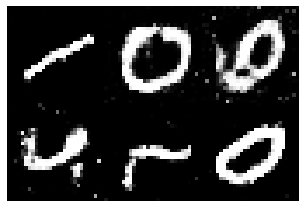

Epoch 73 | Discriminator loss: 1.2260015856226285 | Generator loss: 0.987594315012296


  0%|          | 0/600 [00:00<?, ?it/s]

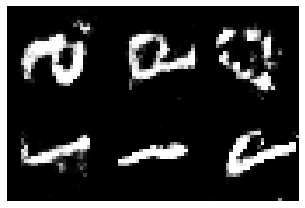

Epoch 74 | Discriminator loss: 1.2305441077550252 | Generator loss: 0.9689930209517479


  0%|          | 0/600 [00:00<?, ?it/s]

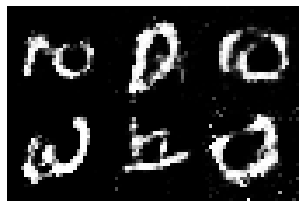

Epoch 75 | Discriminator loss: 1.2272751139601072 | Generator loss: 0.9852846151590348


  0%|          | 0/600 [00:00<?, ?it/s]

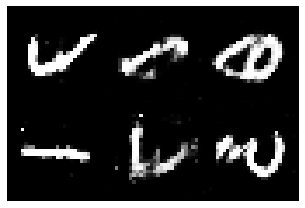

Epoch 76 | Discriminator loss: 1.23138334552447 | Generator loss: 0.9738032510876655


  0%|          | 0/600 [00:00<?, ?it/s]

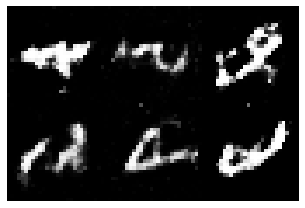

Epoch 77 | Discriminator loss: 1.228582223157088 | Generator loss: 0.9787370562553406


  0%|          | 0/600 [00:00<?, ?it/s]

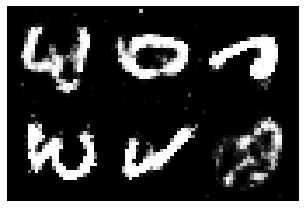

Epoch 78 | Discriminator loss: 1.2342655407389005 | Generator loss: 0.9716828439633052


  0%|          | 0/600 [00:00<?, ?it/s]

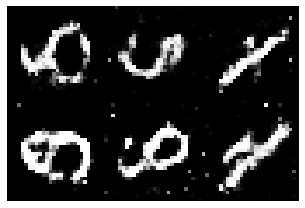

Epoch 79 | Discriminator loss: 1.2293676547209422 | Generator loss: 0.9691374874114991


  0%|          | 0/600 [00:00<?, ?it/s]

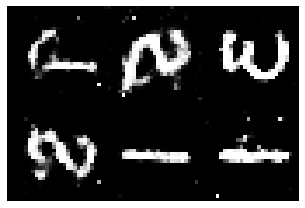

Epoch 80 | Discriminator loss: 1.2297872272133827 | Generator loss: 0.9831868870059649


  0%|          | 0/600 [00:00<?, ?it/s]

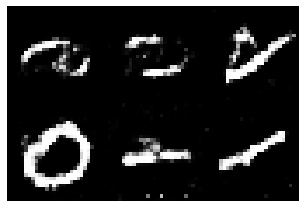

Epoch 81 | Discriminator loss: 1.2352943787972133 | Generator loss: 0.9780472466349601


  0%|          | 0/600 [00:00<?, ?it/s]

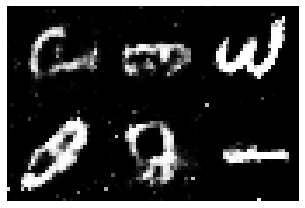

Epoch 82 | Discriminator loss: 1.2390238320827485 | Generator loss: 0.9514728217323621


  0%|          | 0/600 [00:00<?, ?it/s]

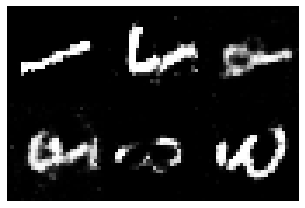

Epoch 83 | Discriminator loss: 1.2397727475563685 | Generator loss: 0.9580263424913088


  0%|          | 0/600 [00:00<?, ?it/s]

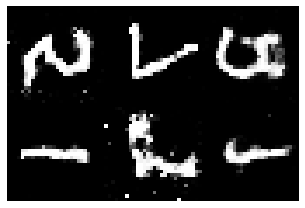

Epoch 84 | Discriminator loss: 1.233622028430303 | Generator loss: 0.9725879051287969


  0%|          | 0/600 [00:00<?, ?it/s]

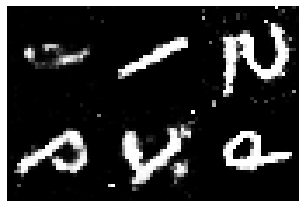

Epoch 85 | Discriminator loss: 1.2388439172506331 | Generator loss: 0.9597631359100341


  0%|          | 0/600 [00:00<?, ?it/s]

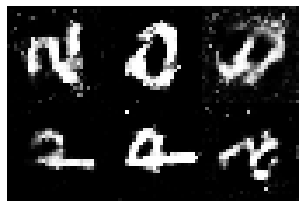

Epoch 86 | Discriminator loss: 1.244954984386762 | Generator loss: 0.9463333429892858


  0%|          | 0/600 [00:00<?, ?it/s]

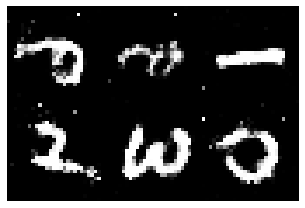

Epoch 87 | Discriminator loss: 1.2369003319740295 | Generator loss: 0.9580143886804581


  0%|          | 0/600 [00:00<?, ?it/s]

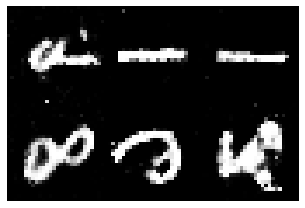

Epoch 88 | Discriminator loss: 1.2342337238788605 | Generator loss: 0.97312901755174


  0%|          | 0/600 [00:00<?, ?it/s]

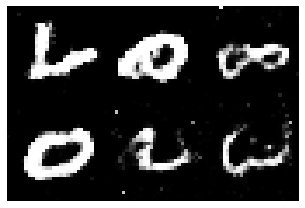

Epoch 89 | Discriminator loss: 1.2443389228979747 | Generator loss: 0.9414851969480514


  0%|          | 0/600 [00:00<?, ?it/s]

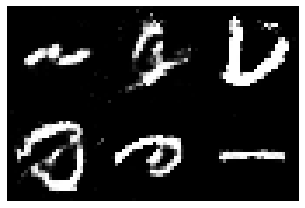

Epoch 90 | Discriminator loss: 1.2420359480381011 | Generator loss: 0.9452970053752263


  0%|          | 0/600 [00:00<?, ?it/s]

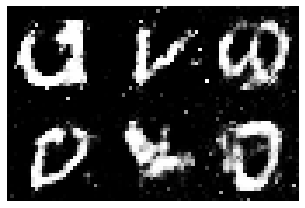

Epoch 91 | Discriminator loss: 1.2423994942506154 | Generator loss: 0.9508941711982092


  0%|          | 0/600 [00:00<?, ?it/s]

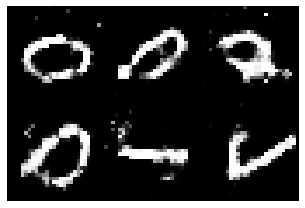

Epoch 92 | Discriminator loss: 1.2397556954622269 | Generator loss: 0.9498645610610644


  0%|          | 0/600 [00:00<?, ?it/s]

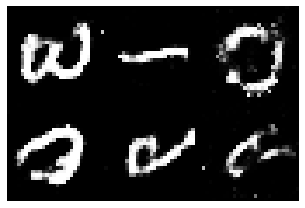

Epoch 93 | Discriminator loss: 1.2490133120616278 | Generator loss: 0.945686794022719


  0%|          | 0/600 [00:00<?, ?it/s]

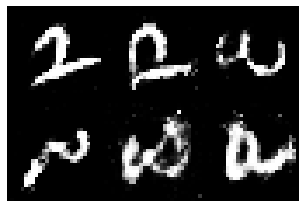

Epoch 94 | Discriminator loss: 1.249322125315666 | Generator loss: 0.941063328286012


  0%|          | 0/600 [00:00<?, ?it/s]

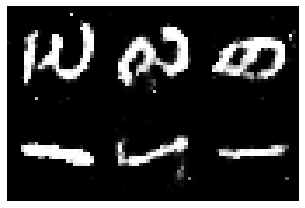

Epoch 95 | Discriminator loss: 1.2510049521923066 | Generator loss: 0.9429312085111936


  0%|          | 0/600 [00:00<?, ?it/s]

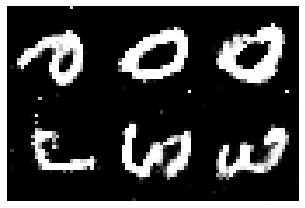

Epoch 96 | Discriminator loss: 1.2540063979228337 | Generator loss: 0.9534709902604421


  0%|          | 0/600 [00:00<?, ?it/s]

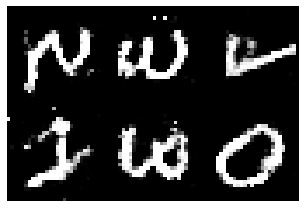

Epoch 97 | Discriminator loss: 1.2405391798416774 | Generator loss: 0.9458357171217601


  0%|          | 0/600 [00:00<?, ?it/s]

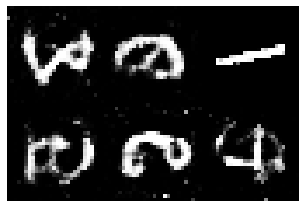

Epoch 98 | Discriminator loss: 1.2537297226985296 | Generator loss: 0.9341576473911604


  0%|          | 0/600 [00:00<?, ?it/s]

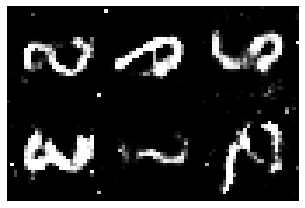

Epoch 99 | Discriminator loss: 1.2614984174569448 | Generator loss: 0.926788134376208


  0%|          | 0/600 [00:00<?, ?it/s]

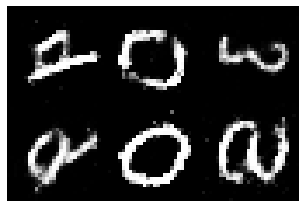

Epoch 100 | Discriminator loss: 1.2468926542003949 | Generator loss: 0.9471642643213272


  0%|          | 0/600 [00:00<?, ?it/s]

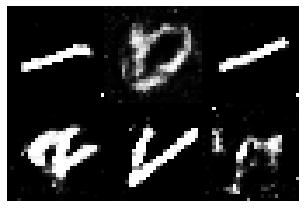

Epoch 101 | Discriminator loss: 1.254055328965187 | Generator loss: 0.9338688919941585


  0%|          | 0/600 [00:00<?, ?it/s]

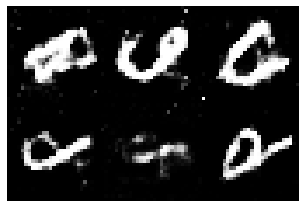

Epoch 102 | Discriminator loss: 1.2540815351406733 | Generator loss: 0.9393941382567088


  0%|          | 0/600 [00:00<?, ?it/s]

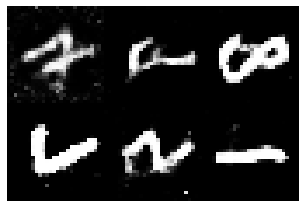

Epoch 103 | Discriminator loss: 1.2513509943087895 | Generator loss: 0.9245332799355189


  0%|          | 0/600 [00:00<?, ?it/s]

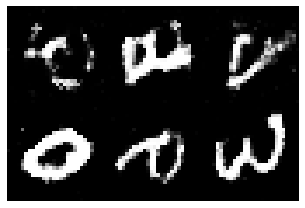

Epoch 104 | Discriminator loss: 1.2552762999137244 | Generator loss: 0.945532519519329


  0%|          | 0/600 [00:00<?, ?it/s]

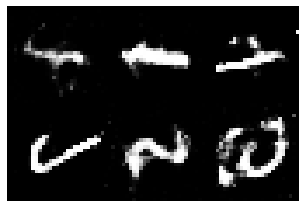

Epoch 105 | Discriminator loss: 1.2453813687960307 | Generator loss: 0.9403306172291438


  0%|          | 0/600 [00:00<?, ?it/s]

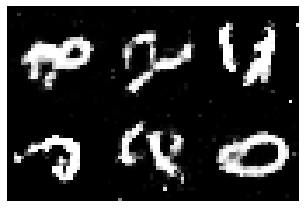

Epoch 106 | Discriminator loss: 1.2529748759667079 | Generator loss: 0.9372082313895226


  0%|          | 0/600 [00:00<?, ?it/s]

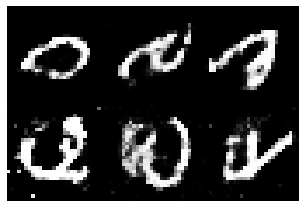

Epoch 107 | Discriminator loss: 1.2584510827064515 | Generator loss: 0.9230421527226766


  0%|          | 0/600 [00:00<?, ?it/s]

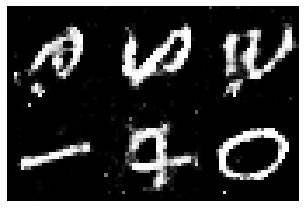

Epoch 108 | Discriminator loss: 1.2571954451004663 | Generator loss: 0.9282865440845489


  0%|          | 0/600 [00:00<?, ?it/s]

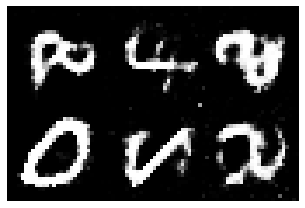

Epoch 109 | Discriminator loss: 1.252357069849968 | Generator loss: 0.9422085651755333


  0%|          | 0/600 [00:00<?, ?it/s]

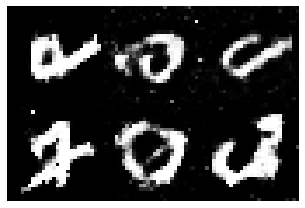

Epoch 110 | Discriminator loss: 1.258622138897578 | Generator loss: 0.9312783031662305


  0%|          | 0/600 [00:00<?, ?it/s]

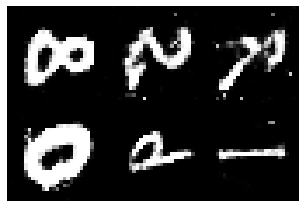

Epoch 111 | Discriminator loss: 1.2511810843149822 | Generator loss: 0.9335963276028633


  0%|          | 0/600 [00:00<?, ?it/s]

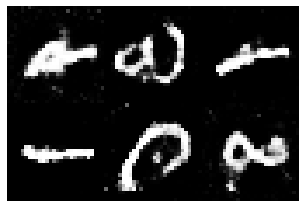

Epoch 112 | Discriminator loss: 1.2634088492393494 | Generator loss: 0.9146071369449298


  0%|          | 0/600 [00:00<?, ?it/s]

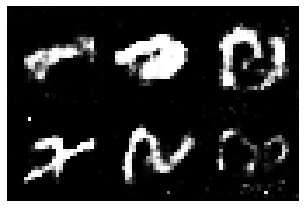

Epoch 113 | Discriminator loss: 1.2598797971010207 | Generator loss: 0.9218529976407687


  0%|          | 0/600 [00:00<?, ?it/s]

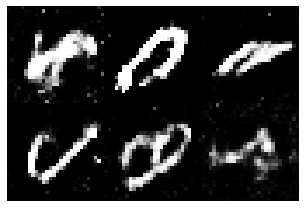

Epoch 114 | Discriminator loss: 1.2569494474927585 | Generator loss: 0.9318206200003624


  0%|          | 0/600 [00:00<?, ?it/s]

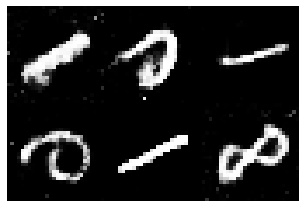

Epoch 115 | Discriminator loss: 1.2575554317235946 | Generator loss: 0.9162527119119962


  0%|          | 0/600 [00:00<?, ?it/s]

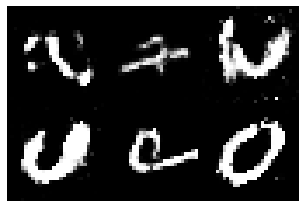

Epoch 116 | Discriminator loss: 1.2625493679443995 | Generator loss: 0.9120380686720212


  0%|          | 0/600 [00:00<?, ?it/s]

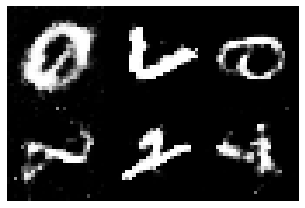

Epoch 117 | Discriminator loss: 1.2695980683962504 | Generator loss: 0.9095445197820663


  0%|          | 0/600 [00:00<?, ?it/s]

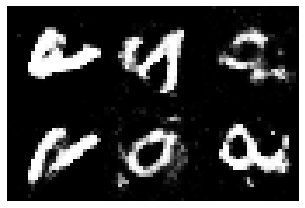

Epoch 118 | Discriminator loss: 1.270469074845314 | Generator loss: 0.9073861443996429


  0%|          | 0/600 [00:00<?, ?it/s]

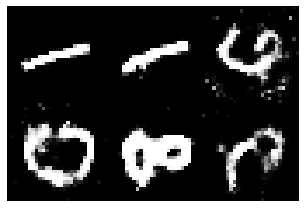

Epoch 119 | Discriminator loss: 1.2609331361452738 | Generator loss: 0.9233773455023766


  0%|          | 0/600 [00:00<?, ?it/s]

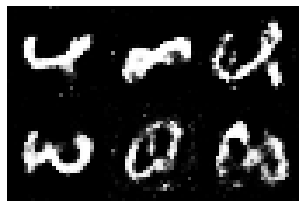

Epoch 120 | Discriminator loss: 1.2684718670447668 | Generator loss: 0.9100650860865911


  0%|          | 0/600 [00:00<?, ?it/s]

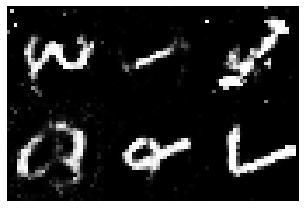

Epoch 121 | Discriminator loss: 1.2670116490125656 | Generator loss: 0.900486112634341


  0%|          | 0/600 [00:00<?, ?it/s]

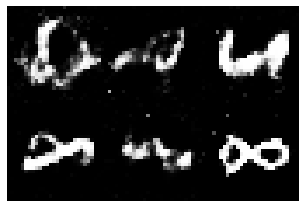

Epoch 122 | Discriminator loss: 1.270198365052541 | Generator loss: 0.9070742254455885


  0%|          | 0/600 [00:00<?, ?it/s]

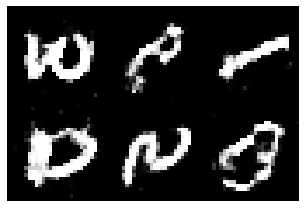

Epoch 123 | Discriminator loss: 1.2704082679748536 | Generator loss: 0.9118592063585917


  0%|          | 0/600 [00:00<?, ?it/s]

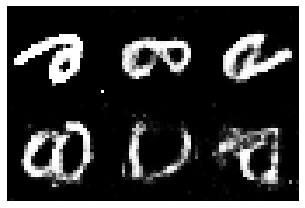

Epoch 124 | Discriminator loss: 1.2629050348202389 | Generator loss: 0.9182932840784391


  0%|          | 0/600 [00:00<?, ?it/s]

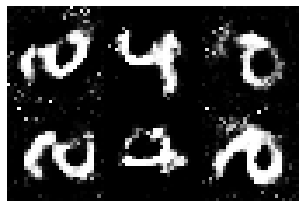

Epoch 125 | Discriminator loss: 1.2640719000498455 | Generator loss: 0.9168051770329475


  0%|          | 0/600 [00:00<?, ?it/s]

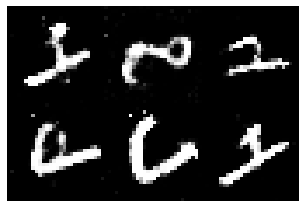

Epoch 126 | Discriminator loss: 1.264531794389089 | Generator loss: 0.9181789896885554


  0%|          | 0/600 [00:00<?, ?it/s]

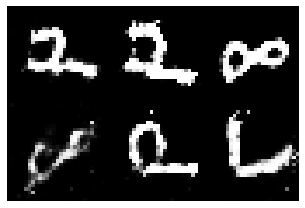

Epoch 127 | Discriminator loss: 1.2711016515890756 | Generator loss: 0.9095873232682546


  0%|          | 0/600 [00:00<?, ?it/s]

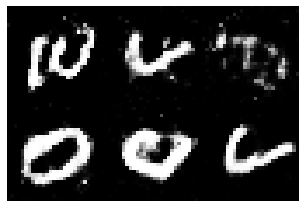

Epoch 128 | Discriminator loss: 1.2657729260126749 | Generator loss: 0.9139142684141794


  0%|          | 0/600 [00:00<?, ?it/s]

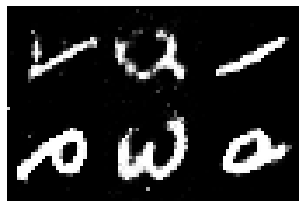

Epoch 129 | Discriminator loss: 1.2664815853039424 | Generator loss: 0.9104261849323908


  0%|          | 0/600 [00:00<?, ?it/s]

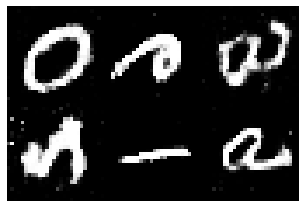

Epoch 130 | Discriminator loss: 1.2668923624356587 | Generator loss: 0.9072621067365011


  0%|          | 0/600 [00:00<?, ?it/s]

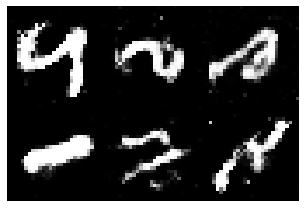

Epoch 131 | Discriminator loss: 1.2691728486617406 | Generator loss: 0.909426107207934


  0%|          | 0/600 [00:00<?, ?it/s]

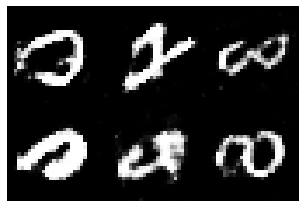

Epoch 132 | Discriminator loss: 1.2722172941764196 | Generator loss: 0.9002701578537623


  0%|          | 0/600 [00:00<?, ?it/s]

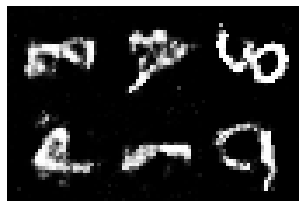

Epoch 133 | Discriminator loss: 1.278598913749059 | Generator loss: 0.8962573155760765


  0%|          | 0/600 [00:00<?, ?it/s]

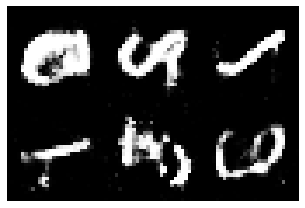

Epoch 134 | Discriminator loss: 1.2723474057515463 | Generator loss: 0.908755571146806


  0%|          | 0/600 [00:00<?, ?it/s]

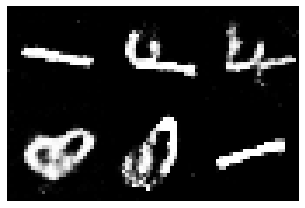

Epoch 135 | Discriminator loss: 1.2615761546293895 | Generator loss: 0.9231651814778646


  0%|          | 0/600 [00:00<?, ?it/s]

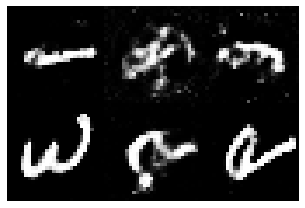

Epoch 136 | Discriminator loss: 1.2630836554368337 | Generator loss: 0.9156644361217817


  0%|          | 0/600 [00:00<?, ?it/s]

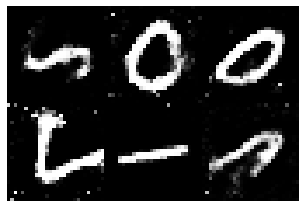

Epoch 137 | Discriminator loss: 1.2660335107644398 | Generator loss: 0.9078564501802127


  0%|          | 0/600 [00:00<?, ?it/s]

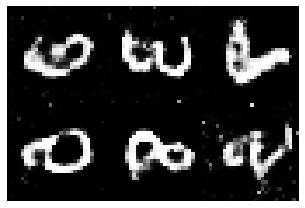

Epoch 138 | Discriminator loss: 1.2712053640683492 | Generator loss: 0.90732060054938


  0%|          | 0/600 [00:00<?, ?it/s]

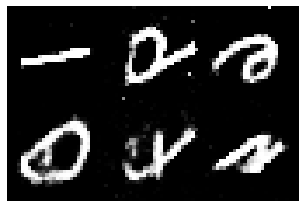

Epoch 139 | Discriminator loss: 1.2677940328915913 | Generator loss: 0.9080886247754097


  0%|          | 0/600 [00:00<?, ?it/s]

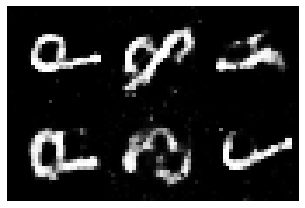

Epoch 140 | Discriminator loss: 1.274468416372935 | Generator loss: 0.8985361524422963


  0%|          | 0/600 [00:00<?, ?it/s]

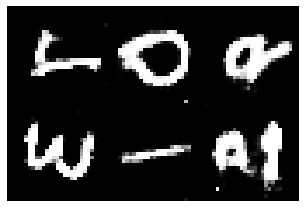

Epoch 141 | Discriminator loss: 1.271472979982694 | Generator loss: 0.898849618335565


  0%|          | 0/600 [00:00<?, ?it/s]

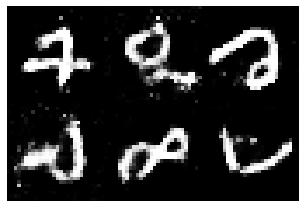

Epoch 142 | Discriminator loss: 1.2671475531657537 | Generator loss: 0.8984968571861585


  0%|          | 0/600 [00:00<?, ?it/s]

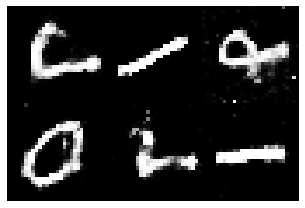

Epoch 143 | Discriminator loss: 1.2722968306144078 | Generator loss: 0.9108940368890762


  0%|          | 0/600 [00:00<?, ?it/s]

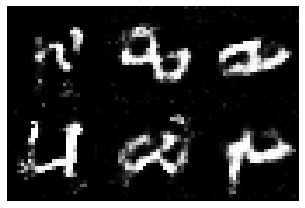

Epoch 144 | Discriminator loss: 1.270270246466001 | Generator loss: 0.9037286661068599


  0%|          | 0/600 [00:00<?, ?it/s]

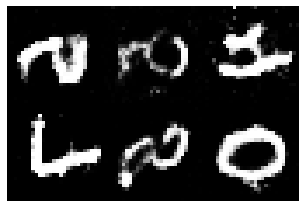

Epoch 145 | Discriminator loss: 1.2711924811204274 | Generator loss: 0.9046613556146622


  0%|          | 0/600 [00:00<?, ?it/s]

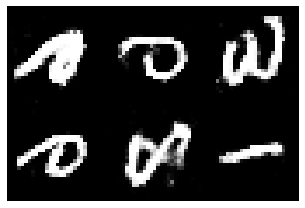

Epoch 146 | Discriminator loss: 1.276509433587392 | Generator loss: 0.8991463724772135


  0%|          | 0/600 [00:00<?, ?it/s]

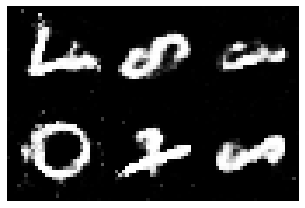

Epoch 147 | Discriminator loss: 1.2692962058385213 | Generator loss: 0.9145197838544845


  0%|          | 0/600 [00:00<?, ?it/s]

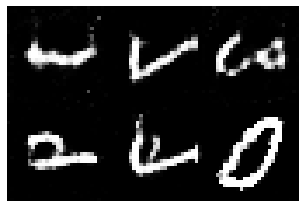

Epoch 148 | Discriminator loss: 1.2655987725655238 | Generator loss: 0.914168417553107


  0%|          | 0/600 [00:00<?, ?it/s]

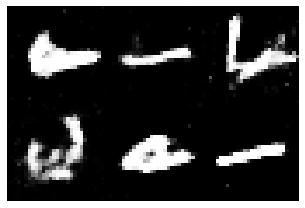

Epoch 149 | Discriminator loss: 1.276017528772354 | Generator loss: 0.9034017293651899


  0%|          | 0/600 [00:00<?, ?it/s]

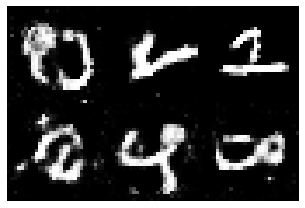

Epoch 150 | Discriminator loss: 1.2743423573176067 | Generator loss: 0.9101300798853238


  0%|          | 0/600 [00:00<?, ?it/s]

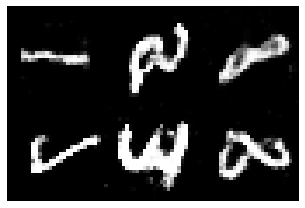

Epoch 151 | Discriminator loss: 1.2766729750235875 | Generator loss: 0.8875118107597033


  0%|          | 0/600 [00:00<?, ?it/s]

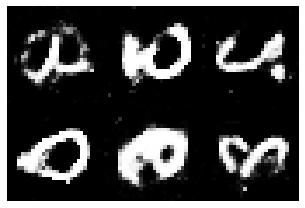

Epoch 152 | Discriminator loss: 1.274100320736567 | Generator loss: 0.8986111514767011


  0%|          | 0/600 [00:00<?, ?it/s]

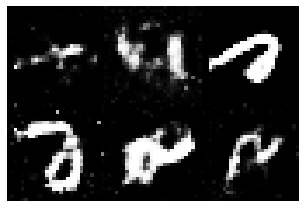

Epoch 153 | Discriminator loss: 1.2756467340389888 | Generator loss: 0.9022250646352767


  0%|          | 0/600 [00:00<?, ?it/s]

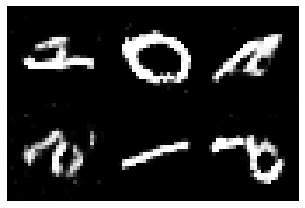

Epoch 154 | Discriminator loss: 1.2773608660697937 | Generator loss: 0.8962448618809382


  0%|          | 0/600 [00:00<?, ?it/s]

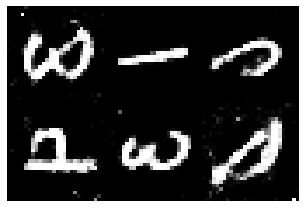

Epoch 155 | Discriminator loss: 1.278200501004855 | Generator loss: 0.8835794854164124


  0%|          | 0/600 [00:00<?, ?it/s]

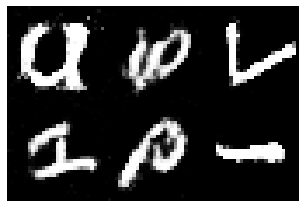

Epoch 156 | Discriminator loss: 1.2812935700019201 | Generator loss: 0.8883850774168969


  0%|          | 0/600 [00:00<?, ?it/s]

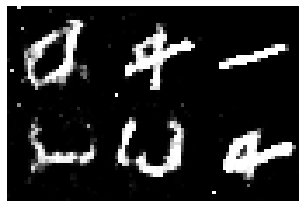

Epoch 157 | Discriminator loss: 1.2747007993857067 | Generator loss: 0.902167087594668


  0%|          | 0/600 [00:00<?, ?it/s]

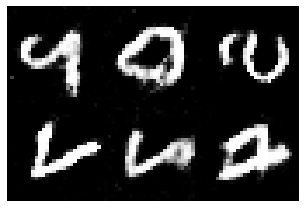

Epoch 158 | Discriminator loss: 1.2711124720176061 | Generator loss: 0.8939777145783107


  0%|          | 0/600 [00:00<?, ?it/s]

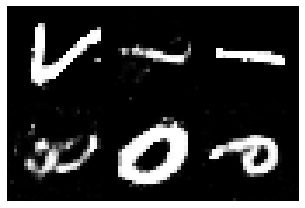

Epoch 159 | Discriminator loss: 1.277930981516838 | Generator loss: 0.9027658673127492


  0%|          | 0/600 [00:00<?, ?it/s]

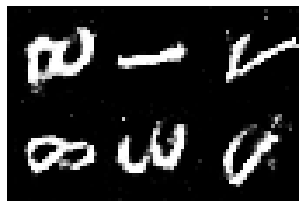

Epoch 160 | Discriminator loss: 1.2753138995170594 | Generator loss: 0.8955277377367019


  0%|          | 0/600 [00:00<?, ?it/s]

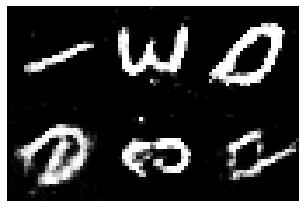

Epoch 161 | Discriminator loss: 1.2753889777263006 | Generator loss: 0.8962261655926704


  0%|          | 0/600 [00:00<?, ?it/s]

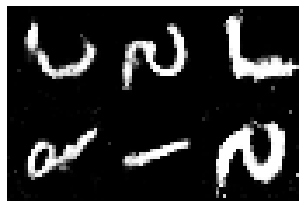

Epoch 162 | Discriminator loss: 1.276921388109525 | Generator loss: 0.8871843711535136


  0%|          | 0/600 [00:00<?, ?it/s]

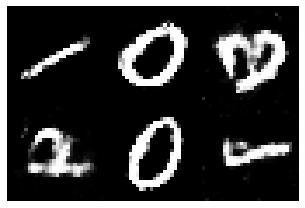

Epoch 163 | Discriminator loss: 1.2744392500321071 | Generator loss: 0.9026966792345047


  0%|          | 0/600 [00:00<?, ?it/s]

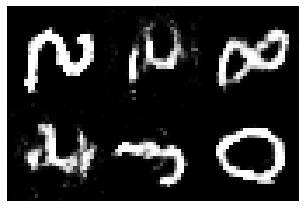

Epoch 164 | Discriminator loss: 1.2753902729352316 | Generator loss: 0.901271193921566


  0%|          | 0/600 [00:00<?, ?it/s]

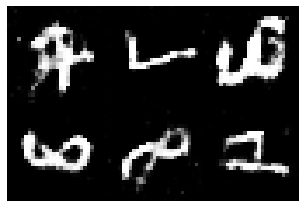

Epoch 165 | Discriminator loss: 1.2807530814409256 | Generator loss: 0.8862895374496778


  0%|          | 0/600 [00:00<?, ?it/s]

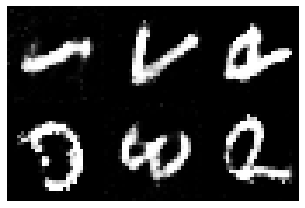

Epoch 166 | Discriminator loss: 1.2779262427488962 | Generator loss: 0.8864896032214165


  0%|          | 0/600 [00:00<?, ?it/s]

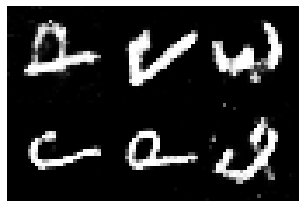

Epoch 167 | Discriminator loss: 1.2851639231046041 | Generator loss: 0.8832317827145258


  0%|          | 0/600 [00:00<?, ?it/s]

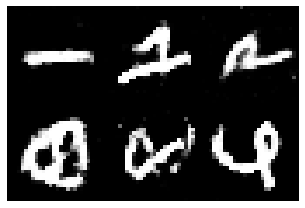

Epoch 168 | Discriminator loss: 1.2842471812168756 | Generator loss: 0.8834408500790596


  0%|          | 0/600 [00:00<?, ?it/s]

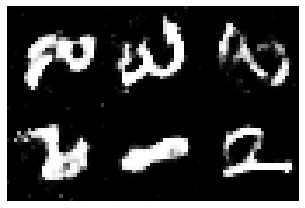

Epoch 169 | Discriminator loss: 1.2775335003932318 | Generator loss: 0.9001231336593628


  0%|          | 0/600 [00:00<?, ?it/s]

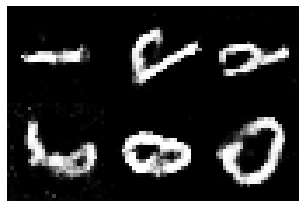

Epoch 170 | Discriminator loss: 1.2825636621316274 | Generator loss: 0.8793306702375412


  0%|          | 0/600 [00:00<?, ?it/s]

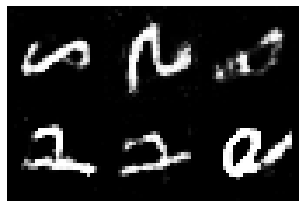

Epoch 171 | Discriminator loss: 1.2891491148869196 | Generator loss: 0.8690139684081077


  0%|          | 0/600 [00:00<?, ?it/s]

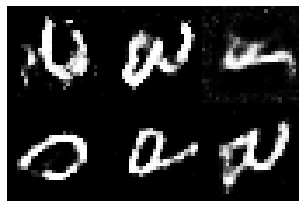

Epoch 172 | Discriminator loss: 1.2825119495391846 | Generator loss: 0.886604010562102


  0%|          | 0/600 [00:00<?, ?it/s]

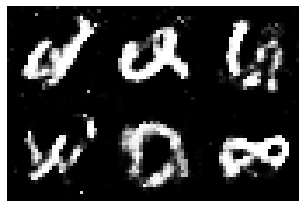

Epoch 173 | Discriminator loss: 1.2781168723106384 | Generator loss: 0.8897799081603686


  0%|          | 0/600 [00:00<?, ?it/s]

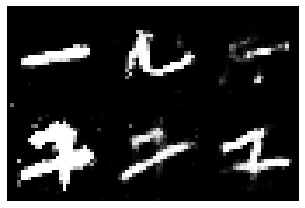

Epoch 174 | Discriminator loss: 1.2790014088153838 | Generator loss: 0.8919914493958155


  0%|          | 0/600 [00:00<?, ?it/s]

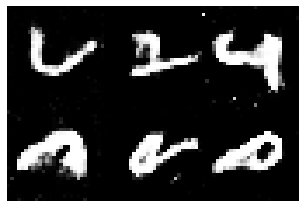

Epoch 175 | Discriminator loss: 1.2732004868984221 | Generator loss: 0.9065585632125537


  0%|          | 0/600 [00:00<?, ?it/s]

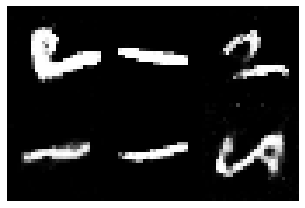

Epoch 176 | Discriminator loss: 1.2845400206247966 | Generator loss: 0.8797568673888843


  0%|          | 0/600 [00:00<?, ?it/s]

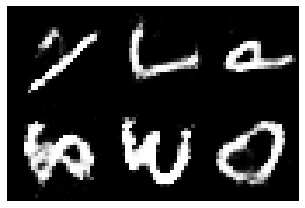

Epoch 177 | Discriminator loss: 1.2808042307694754 | Generator loss: 0.8902666984995207


  0%|          | 0/600 [00:00<?, ?it/s]

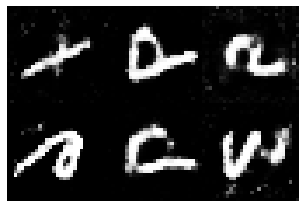

Epoch 178 | Discriminator loss: 1.2812319195270538 | Generator loss: 0.8865788907806078


  0%|          | 0/600 [00:00<?, ?it/s]

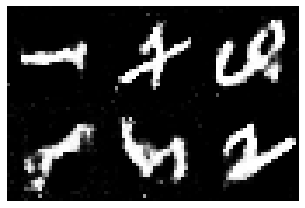

Epoch 179 | Discriminator loss: 1.2854559574524562 | Generator loss: 0.8775612855950992


  0%|          | 0/600 [00:00<?, ?it/s]

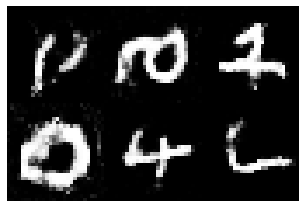

Epoch 180 | Discriminator loss: 1.2844589116175968 | Generator loss: 0.8739108777046204


  0%|          | 0/600 [00:00<?, ?it/s]

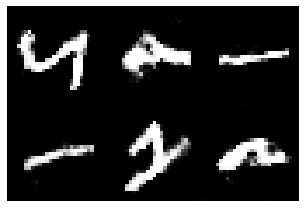

Epoch 181 | Discriminator loss: 1.2884246601661047 | Generator loss: 0.8909727383653323


  0%|          | 0/600 [00:00<?, ?it/s]

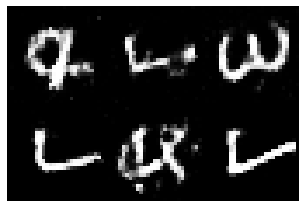

Epoch 182 | Discriminator loss: 1.276709457039833 | Generator loss: 0.8957027033964793


  0%|          | 0/600 [00:00<?, ?it/s]

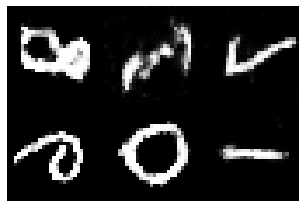

Epoch 183 | Discriminator loss: 1.2769622739156088 | Generator loss: 0.8814781399567923


  0%|          | 0/600 [00:00<?, ?it/s]

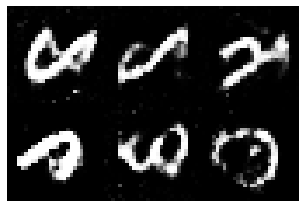

Epoch 184 | Discriminator loss: 1.282904979387919 | Generator loss: 0.8842677864432335


  0%|          | 0/600 [00:00<?, ?it/s]

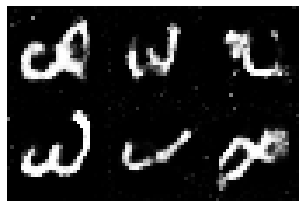

Epoch 185 | Discriminator loss: 1.2803295667966206 | Generator loss: 0.883475592037042


  0%|          | 0/600 [00:00<?, ?it/s]

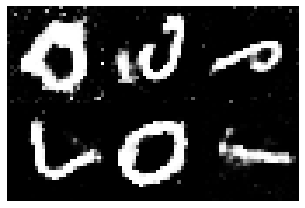

Epoch 186 | Discriminator loss: 1.2875363459189733 | Generator loss: 0.887610657910506


  0%|          | 0/600 [00:00<?, ?it/s]

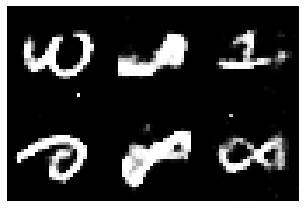

Epoch 187 | Discriminator loss: 1.284459261894226 | Generator loss: 0.873032699127992


  0%|          | 0/600 [00:00<?, ?it/s]

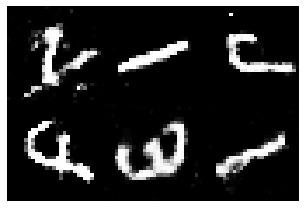

Epoch 188 | Discriminator loss: 1.28046104768912 | Generator loss: 0.878522989054521


  0%|          | 0/600 [00:00<?, ?it/s]

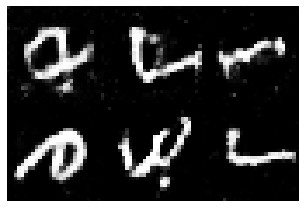

Epoch 189 | Discriminator loss: 1.2818856139977772 | Generator loss: 0.8953690897425016


  0%|          | 0/600 [00:00<?, ?it/s]

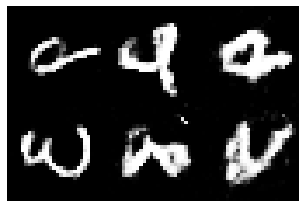

Epoch 190 | Discriminator loss: 1.2822205636898676 | Generator loss: 0.880316335260868


  0%|          | 0/600 [00:00<?, ?it/s]

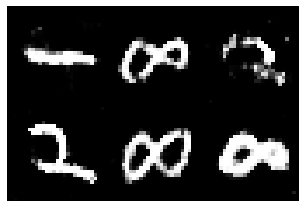

Epoch 191 | Discriminator loss: 1.2856323017676672 | Generator loss: 0.8760724956790606


  0%|          | 0/600 [00:00<?, ?it/s]

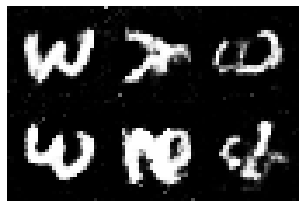

Epoch 192 | Discriminator loss: 1.2800299155712127 | Generator loss: 0.8846557860573133


  0%|          | 0/600 [00:00<?, ?it/s]

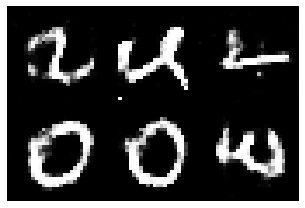

Epoch 193 | Discriminator loss: 1.281231938401858 | Generator loss: 0.8819098475575448


  0%|          | 0/600 [00:00<?, ?it/s]

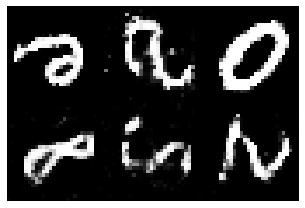

Epoch 194 | Discriminator loss: 1.2788553802172342 | Generator loss: 0.8903980204463005


  0%|          | 0/600 [00:00<?, ?it/s]

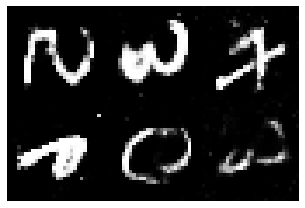

Epoch 195 | Discriminator loss: 1.2832843734820685 | Generator loss: 0.8901174926757812


  0%|          | 0/600 [00:00<?, ?it/s]

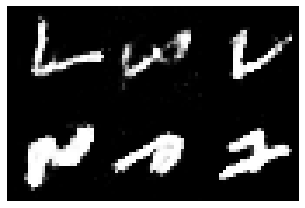

Epoch 196 | Discriminator loss: 1.2810725086927415 | Generator loss: 0.8876004666090012


  0%|          | 0/600 [00:00<?, ?it/s]

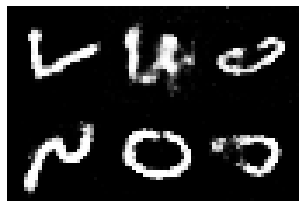

Epoch 197 | Discriminator loss: 1.2883046245574952 | Generator loss: 0.8740233844518661


  0%|          | 0/600 [00:00<?, ?it/s]

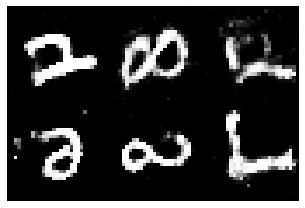

Epoch 198 | Discriminator loss: 1.2863022124767303 | Generator loss: 0.8794277779261271


  0%|          | 0/600 [00:00<?, ?it/s]

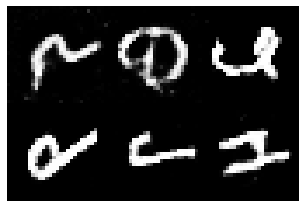

Epoch 199 | Discriminator loss: 1.2830121666193008 | Generator loss: 0.8976343569159507


  0%|          | 0/600 [00:00<?, ?it/s]

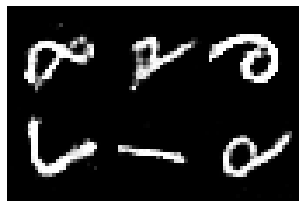

Epoch 200 | Discriminator loss: 1.2848894846439363 | Generator loss: 0.8746524222691854


In [ ]:
for epoch in range(num_epochs):
    total_batches = 0
    gen_loss_avg = 0
    disc_loss_avg = 0
    for num, (real_batch, _) in tqdm(enumerate(data_loader), total=num_batches):

        total_batches += 1
        real_batch_size = real_batch.size(0)
        # Дискриминатор
        real_data = real_batch.view(real_batch_size, 784) # решейпаем в вектор
        real_data = real_data.to(device)
        # генерируем фейковые данные
        fake_data = generator(random_noise(real_batch_size))
        # обучаем дискриминатор
        d_loss = train_discriminator(d_optimizer,
                                    real_data, fake_data)
        disc_loss_avg += d_loss.item()

        # Генератор
        # генерируем фейковые данные
        fake_data = generator(random_noise(real_batch_size))
        # обучаем генератор
        g_loss = train_generator(g_optimizer, fake_data)
        gen_loss_avg += g_loss.item()

        # показать прогресс
    if (epoch + 1) % visualise_every == 0:
        with torch.no_grad():
            visualise(generator(random_noise(6)), rows=2)
    print(f"Epoch {epoch+1} | Discriminator loss: {disc_loss_avg / total_batches} | Generator loss: {gen_loss_avg / total_batches}")
